In [1]:
# imports pandas package
import pandas as pd
# imports numpy package
import numpy as np
# imports matplotlib package
import matplotlib
# imports pylab from matplotlib
from matplotlib import pylab as plt
# imports train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split
# imports KFold from sklearn.model_selection
from sklearn.model_selection import KFold
# imports ColumnTransformer from sklearn.compose
from sklearn.compose import ColumnTransformer
# imports Pipeline from sklearn.pipeline
from sklearn.pipeline import Pipeline
# imports StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

# converts data in the excel file into pandas dataframe
dff = pd.read_csv(r'/Users/jamesro/Documents/DATA1030-Fall2021/Data-1030-Project/Data/student-mat.csv',sep=';')
# converts G3 into binary scale
pass_final = dff.G3 >= 10
fail_final = dff.G3 < 10
dff.loc[pass_final,'G3'] = 1
dff.loc[fail_final,'G3'] = 0
# converts G1 into binary scale
pass_first = dff.G1 >= 10
fail_first = dff.G1 < 10
dff.loc[pass_first,'G1'] = 1
dff.loc[fail_first,'G1'] = 0
# converts G2 into binary scale
pass_sec = dff.G2 >= 10
fail_sec = dff.G2 < 10
dff.loc[pass_sec,'G2'] = 1
dff.loc[fail_sec,'G2'] = 0
# prints dataframe

dff.drop('G2', axis=1, inplace=True)
print(dff)
yy = dff['G3']
XX = dff.loc[:, dff.columns != 'G3']

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

     ... romantic famrel  freetime  goout  Dalc Wal

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

def ML_pipeline_kfold(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']
    cont_ftrs = ['age','Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout','Dalc','Walc','health','absences', 'G1']

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    pipe = make_pipeline(preprocessor,RandomForestClassifier(n_estimators =  100,random_state=random_state))
    # the parameter(s) we want to tune
    rfc_param_grid = {
                   'randomforestclassifier__max_depth': [1, 3, 10, 30, 100], 
                   'randomforestclassifier__max_features': [0.5,0.75,1.0] 
                   } 
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=rfc_param_grid,cv=kf, return_train_score = True,n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = cont_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

In [3]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold(XX,yy,42,5)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)
print(feature_names)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
0.8356646825396826
0.8481012658227848
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.5}
['age' 'Medu' 'Fedu' 'traveltime' 'studytime' 'failures' 'famrel'
 'freetime' 'goout' 'Dalc' 'Walc' 'health' 'absences' 'G1' 'school_GP'
 'school_MS' 'sex_F' 'sex_M' 'address_R' 'address_U' 'famsize_GT3'
 'famsize_LE3' 'Pstatus_A' 'Pstatus_T' 'Mjob_at_home' 'Mjob_health'
 'Mjob_other' 'Mjob_services' 'Mjob_teacher' 'Fjob_at_home' 'Fjob_health'
 'Fjob_other' 'Fjob_services' 'Fjob_teacher' 'reason_course' 'reason_home'
 'reason_other' 'reason_reputation' 'guardian_father' 'guardian_mother'
 'guardian_other' 'schoolsup_no' 'schoolsup_yes' 'famsup_no' 'famsup_yes'
 'paid_no' 'paid_yes' 'activities_no' 'activities_yes' 'nursery_no'
 'nursery_yes' 'higher_no' 'higher_yes' 'internet_no' 'internet_yes'
 'romantic_no' 'romantic_yes']


In [4]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(grid.best_estimator_[1])
# transform the test set
X_test_transformed = grid.best_estimator_[0].transform(X_test)
print(np.shape(X_test_transformed))
shap_values = explainer.shap_values(X_test_transformed)
print(shap_values)
print(np.shape(shap_values))

(79, 57)
[array([[ 0.00099724,  0.        ,  0.00373392, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00824527,  0.        , -0.00113081, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00824527,  0.        , -0.00113081, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00590343,  0.        ,  0.00373392, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00590343,  0.        , -0.00113081, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00099724,  0.        , -0.00113081, ...,  0.        ,
         0.        ,  0.        ]]), array([[-0.00099724,  0.        , -0.00373392, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00824527,  0.        ,  0.00113081, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00824527,  0.        ,  0.00113081, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.00590343,  0.        , -0.00373392, ...,  0.        ,

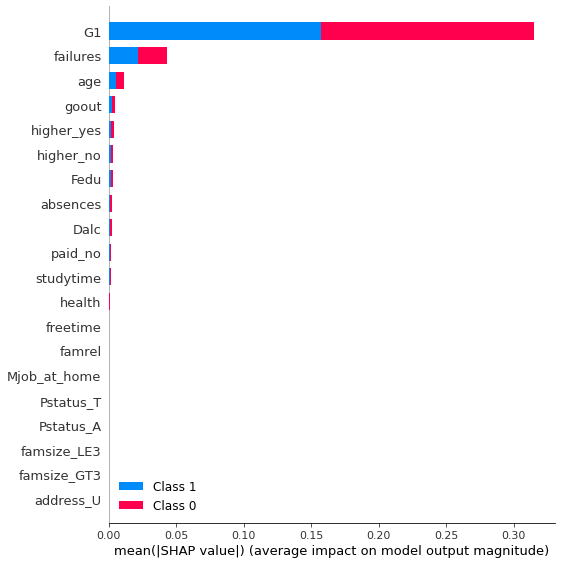

In [5]:
shap.summary_plot(shap_values, X_test_transformed,feature_names = feature_names)

In [6]:
ftr_names = XX.columns
np.random.seed(42)

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 1)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8481012658227848
test baseline =  0.6582278481012658
shuffling school
   shuffled test score: 0.848 +/- 0.0
shuffling sex
   shuffled test score: 0.848 +/- 0.0
shuffling age
   shuffled test score: 0.848 +/- 0.0
shuffling address
   shuffled test score: 0.848 +/- 0.0
shuffling famsize
   shuffled test score: 0.848 +/- 0.0
shuffling Pstatus
   shuffled test score: 0.848 +/- 0.0
shuffling Medu
   shuffled test score: 0.848 +/- 0.0
shuffling Fedu
   shuffled test score: 0.848 +/- 0.0
shuffling Mjob
   shuffled test score: 0.848 +/- 0.0
shuffling Fjob
   shuffled test score: 0.848 +/- 0.0
shuffling reason
   shuffled test score: 0.848 +/- 0.0
shuffling guardian
   shuffled test score: 0.848 +/- 0.0
shuffling traveltime
   shuffled test score: 0.848 +/- 0.0
shuffling studytime
   shuffled test score: 0.848 +/- 0.0
shuffling failures
   shuffled test score: 0.848 +/- 0.0
shuffling schoolsup
   shuffled test score: 0.848 +/- 0.0
shuffling famsup
   shuffled test score: 0.848 +

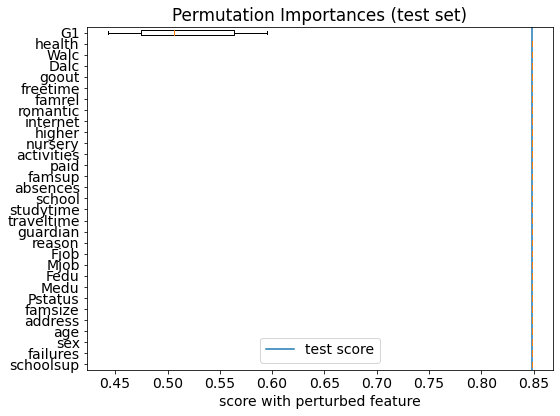

In [7]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend(loc = 'lower center')
plt.tight_layout()
plt.savefig('../figures/perm_imp_wo.jpg', dpi=300)
plt.show()

In [8]:
from sklearn.linear_model import LogisticRegression
def ML_pipeline_kfold_LR2(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']
    cont_ftrs = ['age','Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout','Dalc','Walc','health','absences','G1']

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    final_scaler = StandardScaler()
    pipe = make_pipeline(preprocessor,final_scaler,LogisticRegression(penalty='l2',solver='saga'))
    # the parameter(s) we want to tune
    l2_param_grid = {
                 'logisticregression__C': [1e-2, 1e-1, 1e0, 1e1, 1e2], 
                 'logisticregression__max_iter': [10e5]
                 } 
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=l2_param_grid,cv=kf, return_train_score = True,n_jobs=-1)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = cont_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

test score: 0.810126582278481


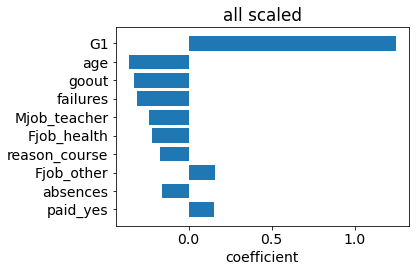

[CV 2/5; 2/15] START randomforestclassifier__max_depth=1, randomforestclassifier__max_features=0.75
[CV 2/5; 2/15] END randomforestclassifier__max_depth=1, randomforestclassifier__max_features=0.75;, score=(train=0.834, test=0.841) total time=   0.4s
[CV 5/5; 3/15] START randomforestclassifier__max_depth=1, randomforestclassifier__max_features=1.0
[CV 5/5; 3/15] END randomforestclassifier__max_depth=1, randomforestclassifier__max_features=1.0;, score=(train=0.826, test=0.873) total time=   0.5s
[CV 3/5; 5/15] START randomforestclassifier__max_depth=3, randomforestclassifier__max_features=0.75
[CV 3/5; 5/15] END randomforestclassifier__max_depth=3, randomforestclassifier__max_features=0.75;, score=(train=0.846, test=0.825) total time=   0.5s
[CV 1/5; 7/15] START randomforestclassifier__max_depth=10, randomforestclassifier__max_features=0.5
[CV 1/5; 7/15] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=0.5;, score=(train=1.000, test=0.766) total time=   0.4

[CV 5/5; 1/15] START randomforestclassifier__max_depth=1, randomforestclassifier__max_features=0.5
[CV 5/5; 1/15] END randomforestclassifier__max_depth=1, randomforestclassifier__max_features=0.5;, score=(train=0.830, test=0.873) total time=   0.4s
[CV 2/5; 3/15] START randomforestclassifier__max_depth=1, randomforestclassifier__max_features=1.0
[CV 2/5; 3/15] END randomforestclassifier__max_depth=1, randomforestclassifier__max_features=1.0;, score=(train=0.834, test=0.841) total time=   0.4s
[CV 5/5; 4/15] START randomforestclassifier__max_depth=3, randomforestclassifier__max_features=0.5
[CV 5/5; 4/15] END randomforestclassifier__max_depth=3, randomforestclassifier__max_features=0.5;, score=(train=0.866, test=0.857) total time=   0.5s
[CV 3/5; 6/15] START randomforestclassifier__max_depth=3, randomforestclassifier__max_features=1.0
[CV 3/5; 6/15] END randomforestclassifier__max_depth=3, randomforestclassifier__max_features=1.0;, score=(train=0.854, test=0.857) total time=   0.4s
[CV 

In [9]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold_LR2(XX,yy,42,5)
print('test score:',grid.score(X_test,y_test))
coefs = grid.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('all scaled')
plt.tight_layout()
plt.savefig('../figures/LR_coefs_scaled_wo.jpg',dpi=300)
plt.show()